In [2]:
!pip install "numpy<1.24"

In [3]:
import numpy as np

np.__version__

'1.23.5'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox --quiet

Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007 (from 1)
Receiving objects: 100% (2007/2007), 79.60 MiB | 31.77 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.8.0 (from versions: 1.15.0, 1.15.1, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.17.0, 1.17.1, 1.17.3, 1.18.0, 1.18.1, 1.19.0, 1.19.2, 1.20.0, 1.20.1)
ERROR: No matching distribution found for onnxruntime==1.8.0
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running develop
/usr/local

In [6]:
!pip install ultralytics --quiet
!pip install onemetric --quiet
!pip install loguru --quiet
!pip install lap --quiet
!pip install motmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [7]:
import sys
sys.path.append("ByteTrack")

In [8]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from tqdm import tqdm
import numpy as np
import cv2
from dataclasses import dataclass
import pandas as pd
from pathlib import Path
import motmetrics as mm
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Me

In [ ]:
def get_image_frames(image_folder_path, desired_size=None):

    valid_extensions = ('.png', '.jpg', '.jpeg')
    images = sorted([
        img for img in os.listdir(image_folder_path)
        if img.lower().endswith(valid_extensions)
    ])

    if not images:
        raise ValueError("No images found in the specified directory.")

    frames = []
    for img_name in images:
        img_path = os.path.join(image_folder_path, img_name)
        frame = cv2.imread(img_path)

        if frame is None:
            print(f"Warning: Unable to read image {img_path}. Skipping.")
            continue

        if desired_size is not None:
            frame = cv2.resize(frame, desired_size)

        frames.append(frame)

    if not frames:
        raise ValueError("No valid images were read from the directory.")

    return frames

image_folder = "/content/drive/My Drive/SportsMOT/test/img1"

frames = get_image_frames(image_folder)

In [ ]:
path_weights = "/content/drive/My Drive/SportsMOT/Yolov8-fine.pt"

yolo_model = YOLO(path_weights)

ind_to_cls = {
    0: "player",
    1 : "ball",
    2 : "referee",
    3 : "goalkeeper"
}

colors = {
    "ball": (0,200,200),
    "player": (255,255,0),
    "goalkeeper":(255,0,255),
    "referee": (0,0,255),
}

In [ ]:
def format_predictions(predictions, with_conf: bool = True):
  """
  Format yolo detection to ByteTracke format: (x1, y1, x2, y2, conf)
  """
  frame_detections = []
  for pred in predictions:
      bbox = pred.boxes.xyxy.int().tolist()[0]
      conf = pred.boxes.conf.item()
      if with_conf:
        detection = bbox + [conf]
      else:
        detection = bbox

      frame_detections.append(detection)
  return np.array(frame_detections, dtype=float)


In [ ]:
def match_detections_with_tracks(detections, tracks):
  """
  Find which tracker corresponds to yolo detections and set the tracker_id.
  We compute the iou between the detection and trackers.
  """
  detections_bboxes = format_predictions(detections, with_conf=False)
  tracks_bboxes = np.array([track.tlbr for track in tracks], dtype=float)
  iou = box_iou_batch(tracks_bboxes, detections_bboxes)
  track2detection = np.argmax(iou, axis=1)

  for tracker_index, detection_index in enumerate(track2detection):
    if iou[tracker_index, detection_index] != 0:
      detections[detection_index].tracker_id = tracks[tracker_index].track_id
  return detections

In [ ]:
import cv2
import numpy as np

def draw_detections(image, detections, draw_confidence: bool = False, draw_tacker_id: bool = False):

    image = image.copy()

    for pred in detections:
        # Extract bounding box coordinates
        bbox = pred.boxes.xyxy.int().tolist()[0]

        # Extract class index and map to class name
        cls_ind = pred.boxes.cls.int().item()
        cls = ind_to_cls[cls_ind]

        # Extract confidence score
        conf = pred.boxes.conf.item()

        # Define colors
        color = colors[cls]
        text_color = (255, 255, 255)  # White text for visibility
        box_opacity = 0.6  # Transparency level for text background

        if draw_tacker_id:
            # Prepare text to display
            text = f"{str(pred.tracker_id)}. {cls} ({conf:.2f})" if draw_confidence else cls
        else:
            text = f"{cls} ({conf:.2f})" if draw_confidence else cls

        # Calculate text size
        font_scale = 0.6
        font_thickness = 2
        (text_w, text_h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)

        # Bounding box coordinates
        x1, y1, x2, y2 = bbox
        box_w = x2 - x1  # Width of player box
        box_h = y2 - y1  # Height of player box

        # Position text box symmetrically at the top of the bounding box
        text_bg_x1 = x1 + (box_w - text_w) // 2  # Centering horizontally
        text_bg_y1 = y1 - text_h - 12  # Above the bounding box with padding
        text_bg_x2 = text_bg_x1 + text_w + 10  # Width matching text
        text_bg_y2 = y1 - 5  # Aligning with top of bounding box

        # Ensure text box stays within image bounds
        if text_bg_y1 < 0:
            text_bg_y1 = y1 + box_h + 5  # Move inside the box if it overflows
            text_bg_y2 = text_bg_y1 + text_h + 5

        # Draw semi-transparent text background
        overlay = image.copy()
        cv2.rectangle(overlay, (text_bg_x1, text_bg_y1), (text_bg_x2, text_bg_y2), color, -1)
        image = cv2.addWeighted(overlay, box_opacity, image, 1 - box_opacity, 0)  # Blend transparency

        # Draw bounding box with rounded corners
        radius = 8
        thickness = 3
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

        # Draw text with shadow effect
        text_x = text_bg_x1 + 5
        text_y = text_bg_y2 - 5
        cv2.putText(image, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, 4)  # Shadow
        cv2.putText(image, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness)  # Main text

    return image


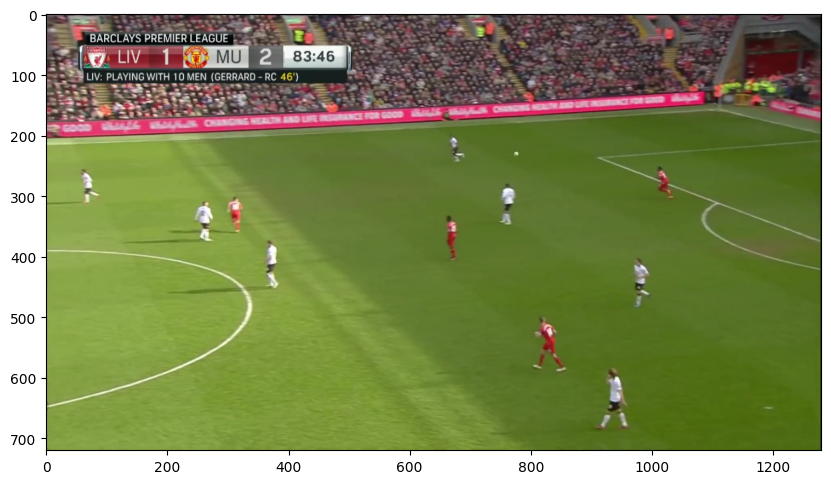

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()


0: 384x640 11 players, 313.4ms
Speed: 15.4ms preprocess, 313.4ms inference, 35.5ms postprocess per image at shape (1, 3, 384, 640)


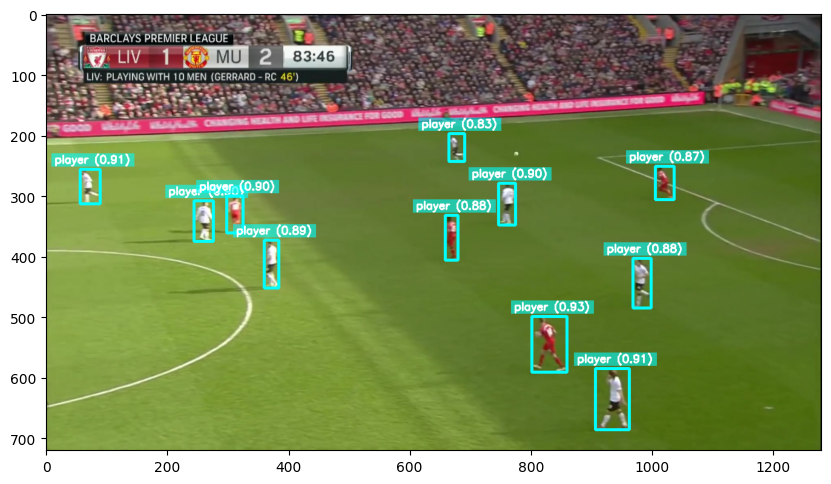

In [ ]:
prediction = yolo_model(frames[0])

image1 = draw_detections(frames[0], prediction[0], draw_confidence = True)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.show()

## Tracking without grid search

In [ ]:
@dataclass(frozen=True)
class BYTETrackerArgs:
  track_thresh: float = 0.25
  track_buffer: int = 30
  match_thresh: float = 0.8
  aspect_ratio_thresh: float = 3.0
  min_box_area: float = 1.0
  mot20: bool = False


In [ ]:
# initiate tracker
byte_tracker = BYTETracker(BYTETrackerArgs)

In [ ]:
tracking_results = []
images = []

for frame_idx, frame in enumerate(tqdm(frames), start=1):

    # detect players with yolo
    detections = yolo_model(frame, verbose=False)[0]

    # create a new list of detection with tracker_id attribute.
    detections_with_tracker = []
    for detection in detections:
      detection.tracker_id = ""
      detections_with_tracker.append(detection)

    # get trackers with ByteTrack
    tracks = byte_tracker.update(
        output_results=format_predictions(detections_with_tracker, with_conf=True),
        img_info=frame.shape,
        img_size=frame.shape
    )

    # set tracker_id in yolo detections
    detections_with_tracker = match_detections_with_tracks(detections_with_tracker, tracks)

    for detection in detections_with_tracker:
        if detection.tracker_id == "":  # Skip untracked detections
            continue

        bbox = detection.boxes.xyxy[0].tolist()
        x1, y1, x2, y2 = bbox
        w, h = x2 - x1, y2 - y1

        tracking_results.append([
            frame_idx,
            int(detection.tracker_id),
            x1, y1, w, h,
            1,  # Detection confidence (set to 1 for MOT format)
            -1, -1, -1  # Required placeholders
        ])

    image = draw_detections(frame, detections_with_tracker, True)
    images.append(image)

# Save tracking results to file
results_df = pd.DataFrame(tracking_results, columns=[
    'frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z'
])
results_df.to_csv('/content/drive/My Drive/SportsMOT/test/tracking_results.txt', sep=',', index=False, header=False)

100%|██████████| 451/451 [01:32<00:00,  4.89it/s]


In [ ]:
import pandas as pd

# Read your 9-column GT file
gt_df = pd.read_csv(
    "/content/drive/My Drive/SportsMOT/test/gt/gt.txt",
    header=None,
    names=[
        "frame", "id", "bb_left", "bb_top",
        "bb_width", "bb_height", "conf", "x", "y"
    ]
)

# Add placeholder `z` column (required by MOT format)
gt_df["x"] = -1  # or np.nan
gt_df["y"] = -1  # or np.nan
gt_df["z"] = -1  # or np.nan

# Save corrected GT temporarily (optional)
gt_df.to_csv("/content/drive/My Drive/SportsMOT/test/gt/corrected_gt.txt", index=False, header=False)

In [ ]:
# Load data
gt_file = '/content/drive/My Drive/SportsMOT/test/gt/corrected_gt.txt'  # Update this path
ts_file = '/content/drive/My Drive/SportsMOT/test/tracking_results.txt'

# Load ground truth and tracking results
gt = mm.io.load_motchallenge(gt_file)
ts = mm.io.load_motchallenge(ts_file)

# Calculate metrics
acc = mm.utils.compare_to_groundtruth(gt, ts, 'iou', distth=0.5)
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=[
    'mota', 'motp', 'idf1', 'idp', 'idr',
    'num_switches', 'mostly_tracked',
    'partially_tracked', 'mostly_lost'
], name='acc')

# Convert to pandas DataFrame for better visualization
summary_df = pd.DataFrame(summary).transpose()
print("\nTracking Metrics:")
print(summary_df)


Tracking Metrics:
                         acc
mota                0.826015
motp                0.115531
idf1                0.791357
idp                 0.768645
idr                 0.815452
num_switches       28.000000
mostly_tracked     20.000000
partially_tracked   1.000000
mostly_lost         0.000000


In [ ]:
def images_to_video(image_list, output_video, frame_rate=25):
    if not image_list:
        print("No images in the list!")
        return

    height, width, _ = image_list[0].shape

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for MP4
    video = cv2.VideoWriter(output_video, fourcc, frame_rate, (width, height))

    for img in image_list:
        video.write(img)

    video.release()
    print(f"Video saved as {output_video}")

images_to_video(images, output_video = "/content/drive/My Drive/SportsMOT/test/tracked.mp4")

Video saved as /content/drive/My Drive/SportsMOT/test/tracked.mp4


## Grid Search

In [ ]:
import motmetrics as mm
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

def calculate_mota(gt_file, ts_file):
    """Calculate MOT metrics from files"""
    # Load ground truth and tracking results from files
    gt = mm.io.load_motchallenge(gt_file)
    ts = mm.io.load_motchallenge(ts_file)

    # Calculate metrics
    acc = mm.utils.compare_to_groundtruth(gt, ts, distth=0.5)
    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=mm.metrics.motchallenge_metrics)
    return summary['mota']  # Return MOTA directly

def run_tracking_with_params(frames, detections_cache, params):
    """Run tracking and return MOTA"""
    tracker_args = BYTETrackerArgs(**params)
    tracker = BYTETracker(tracker_args)

    # File paths - use consistent locations
    gt_file = '/content/drive/My Drive/SportsMOT/test/gt/corrected_gt.txt'
    ts_file = '/content/drive/My Drive/SportsMOT/test/tracking_results_aux.txt'

    tracking_results = []
    for frame_idx, (frame, dets) in enumerate(zip(frames, detections_cache), start=1):
        tracks = tracker.update(
            output_results=dets,
            img_info=frame.shape,
            img_size=frame.shape
        )

        # Format tracks properly
        for track in tracks:
            x1, y1, x2, y2 = track.tlbr
            tracking_results.append([
                frame_idx,
                track.track_id,
                x1, y1, x2-x1, y2-y1,  # Convert to tlwh
                -1, -1, -1, -1  # Required placeholders
            ])

    # Save tracking results
    pd.DataFrame(tracking_results).to_csv(ts_file, index=False, header=False)

    # Calculate metrics
    return calculate_mota(gt_file, ts_file)

param_grid = {
    'track_thresh': [0.15, 0.2, 0.25, 0.3],  # Detection confidence threshold
    'match_thresh': [0.7, 0.8, 0.9],         # Matching threshold for tracking
    'track_buffer': [25, 30, 35],            # Number of frames to buffer lost tracks
    'min_box_area': [10, 50, 100],
}

# Run grid search
best_mota = -np.inf
best_params = None

for params in tqdm(list(ParameterGrid(param_grid))):
    current_mota = run_tracking_with_params(frames, detections_cache, params)

    if current_mota[0] > best_mota:
        best_mota = current_mota[0]
        best_params = params


print(f"\nBest MOTA: {best_mota:.2f} with params: {best_params}")

100%|██████████| 108/108 [03:40<00:00,  2.04s/it]


Best MOTA: 0.82 with params: {'match_thresh': 0.8, 'min_box_area': 10, 'track_buffer': 25, 'track_thresh': 0.3}


# Sportsmot finetuned after grid search

In [ ]:
@dataclass(frozen=True)
class BYTETrackerArgs:
  track_thresh: float = 0.3
  track_buffer: int = 25
  match_thresh: float = 0.8
  aspect_ratio_thresh: float = 3.0
  min_box_area: float = 10.0
  mot20: bool = False

byte_tracker = BYTETracker(BYTETrackerArgs)

In [ ]:
tracking_results = []
images = []

# Store detections for later tracker ID mapping
all_detections = []

# Step 1: Process each frame
for frame_idx, frame in enumerate(tqdm(frames), start=1):

    # Detect players with YOLO
    detections = yolo_model(frame, verbose=False)[0]

    # Create a new list of detection with tracker_id attribute
    detections_with_tracker = []
    for detection in detections:
        detection.tracker_id = ""
        detections_with_tracker.append(detection)

    # Get trackers with ByteTrack
    tracks = byte_tracker.update(
        output_results=format_predictions(detections_with_tracker, with_conf=True),
        img_info=frame.shape,
        img_size=frame.shape
    )

    # Set tracker_id in YOLO detections
    detections_with_tracker = match_detections_with_tracks(detections_with_tracker, tracks)

    # Store detections for later tracker ID update
    all_detections.append(detections_with_tracker)

    # Step 2: Collect tracking results and assign new tracker IDs
    for detection in detections_with_tracker:
        if detection.tracker_id == "":  # Skip untracked detections
            continue

        bbox = detection.boxes.xyxy[0].tolist()
        x1, y1, x2, y2 = bbox
        w, h = x2 - x1, y2 - y1

        tracking_results.append([
            frame_idx,
            int(detection.tracker_id),
            x1, y1, w, h,
            1,  # Detection confidence (set to 1 for MOT format)
            -1, -1, -1  # Required placeholders
        ])

# Step 3: Assign new tracker IDs starting from 1
tracker_id_mapping = {}
current_id = 1

for frame_idx, detections in enumerate(all_detections):
    for detection in detections:
        if detection.tracker_id == "":  # Skip untracked detections
            continue

        # If this tracker_id hasn't been assigned a new ID, assign it now
        if detection.tracker_id not in tracker_id_mapping:
            tracker_id_mapping[detection.tracker_id] = current_id
            current_id += 1

        # Apply the new tracker_id
        detection.tracker_id = tracker_id_mapping[detection.tracker_id]

# Step 4: Draw detections after updating tracker IDs
for frame_idx, frame in enumerate(tqdm(frames), start=1):
    detections = all_detections[frame_idx - 1]  # Get stored detections for the frame
    # Draw the detections and add to image list
    image_with_detections = draw_detections(frame, detections, True, True)
    images.append(image_with_detections)


100%|██████████| 451/451 [00:10<00:00, 41.76it/s]


In [ ]:
results_df = pd.DataFrame(tracking_results, columns=[
    'frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z'
])
results_df.to_csv('/content/drive/My Drive/SportsMOT/test/tracking_results_with_grid_search_best.txt', sep=',', index=False, header=False)

In [ ]:
# Load data
gt_file = '/content/drive/My Drive/SportsMOT/test/gt/corrected_gt.txt'  # Update this path
ts_file = '/content/drive/My Drive/SportsMOT/test/tracking_results_with_grid_search_best.txt'

# Load ground truth and tracking results
gt = mm.io.load_motchallenge(gt_file)
ts = mm.io.load_motchallenge(ts_file)

# Calculate metrics
acc = mm.utils.compare_to_groundtruth(gt, ts, 'iou', distth=0.5)
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=[
    'mota', 'motp', 'idf1', 'idp', 'idr',
    'num_switches', 'mostly_tracked',
    'partially_tracked', 'mostly_lost'
], name='acc')

# Convert to pandas DataFrame for better visualization
summary_df = pd.DataFrame(summary).transpose()
print("\nTracking Metrics:")
print(summary_df)


Tracking Metrics:
                         acc
mota                0.871375
motp                0.108378
idf1                0.848928
idp                 0.822080
idr                 0.877589
num_switches       27.000000
mostly_tracked     21.000000
partially_tracked   0.000000
mostly_lost         0.000000


In [ ]:
def images_to_video(image_list, output_video, frame_rate=25):
    if not image_list:
        print("No images in the list!")
        return

    height, width, _ = image_list[0].shape

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for MP4
    video = cv2.VideoWriter(output_video, fourcc, frame_rate, (width, height))

    for img in image_list:
        video.write(img)

    video.release()
    print(f"Video saved as {output_video}")

images_to_video(images, output_video = "/content/drive/My Drive/SportsMOT/test/tracked_with_grid_search_best.mp4")

Video saved as /content/drive/My Drive/SportsMOT/test/tracked_with_grid_search_best.mp4


## Soccernet fine-tuned model after grid search

In [ ]:
tracking_results = []
images = []

# Store detections for later tracker ID mapping
all_detections = []

# Step 1: Process each frame
for frame_idx, frame in enumerate(tqdm(frames), start=1):

    # Detect players with YOLO
    detections = yolo_model(frame, verbose=False)[0]

    # Create a new list of detection with tracker_id attribute
    detections_with_tracker = []
    for detection in detections:
        detection.tracker_id = ""
        detections_with_tracker.append(detection)

    # Get trackers with ByteTrack
    tracks = byte_tracker.update(
        output_results=format_predictions(detections_with_tracker, with_conf=True),
        img_info=frame.shape,
        img_size=frame.shape
    )

    # Set tracker_id in YOLO detections
    detections_with_tracker = match_detections_with_tracks(detections_with_tracker, tracks)

    # Store detections for later tracker ID update
    all_detections.append(detections_with_tracker)

    # Step 2: Collect tracking results and assign new tracker IDs
    for detection in detections_with_tracker:
        if detection.tracker_id == "":  # Skip untracked detections
            continue

        bbox = detection.boxes.xyxy[0].tolist()
        x1, y1, x2, y2 = bbox
        w, h = x2 - x1, y2 - y1

        tracking_results.append([
            frame_idx,
            int(detection.tracker_id),
            x1, y1, w, h,
            1,  # Detection confidence (set to 1 for MOT format)
            -1, -1, -1  # Required placeholders
        ])

# Step 3: Assign new tracker IDs starting from 1
tracker_id_mapping = {}
current_id = 1

for frame_idx, detections in enumerate(all_detections):
    for detection in detections:
        if detection.tracker_id == "":  # Skip untracked detections
            continue

        # If this tracker_id hasn't been assigned a new ID, assign it now
        if detection.tracker_id not in tracker_id_mapping:
            tracker_id_mapping[detection.tracker_id] = current_id
            current_id += 1

        # Apply the new tracker_id
        detection.tracker_id = tracker_id_mapping[detection.tracker_id]

# Step 4: Draw detections after updating tracker IDs
for frame_idx, frame in enumerate(tqdm(frames), start=1):
    detections = all_detections[frame_idx - 1]  # Get stored detections for the frame
    # Draw the detections and add to image list
    image_with_detections = draw_detections(frame, detections, True, True)
    images.append(image_with_detections)


100%|██████████| 451/451 [00:14<00:00, 31.27it/s]


In [ ]:
results_df = pd.DataFrame(tracking_results, columns=[
    'frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z'
])
results_df.to_csv('/content/drive/My Drive/SportsMOT/test/tracking_results_with_grid_search_fine.txt', sep=',', index=False, header=False)

In [ ]:
# Load data
gt_file = '/content/drive/My Drive/SportsMOT/test/gt/corrected_gt.txt'  # Update this path
ts_file = '/content/drive/My Drive/SportsMOT/test/tracking_results_with_grid_search_fine.txt'

# Load ground truth and tracking results
gt = mm.io.load_motchallenge(gt_file)
ts = mm.io.load_motchallenge(ts_file)

# Calculate metrics
acc = mm.utils.compare_to_groundtruth(gt, ts, 'iou', distth=0.5)
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=[
    'mota', 'motp', 'idf1', 'idp', 'idr',
    'num_switches', 'mostly_tracked',
    'partially_tracked', 'mostly_lost'
], name='acc')

# Convert to pandas DataFrame for better visualization
summary_df = pd.DataFrame(summary).transpose()
print("\nTracking Metrics:")
print(summary_df)


Tracking Metrics:
                         acc
mota                0.796810
motp                0.114806
idf1                0.797989
idp                 0.775454
idr                 0.821872
num_switches       22.000000
mostly_tracked     18.000000
partially_tracked   3.000000
mostly_lost         0.000000


In [ ]:
def images_to_video(image_list, output_video, frame_rate=25):
    if not image_list:
        print("No images in the list!")
        return

    height, width, _ = image_list[0].shape

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for MP4
    video = cv2.VideoWriter(output_video, fourcc, frame_rate, (width, height))

    for img in image_list:
        video.write(img)

    video.release()
    print(f"Video saved as {output_video}")

images_to_video(images, output_video = "/content/drive/My Drive/SportsMOT/test/tracked_with_grid_search_fine.mp4")

Video saved as /content/drive/My Drive/SportsMOT/test/tracked_with_grid_search_fine.mp4


# TA

In [21]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.3
    track_buffer: int = 25
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 10.0
    mot20: bool = False

class VideoTracker:
    def __init__(self, video_path, path_weights, output_video_path,
                 gt_path=None, desired_size=None, frame_rate=25):
        """
        Args:
            video_path (str): Path to the input video.
            path_weights (str): Path to YOLO weights.
            output_video_path (str): Path to save the output video.
            gt_path (str or None): Path to ground-truth file (if None, metrics are skipped).
            desired_size (tuple or None): Resize dimensions (width, height) for frames.
            frame_rate (int): Frame rate for the output video.
        """
        self.video_path = video_path
        self.path_weights = path_weights
        self.output_video_path = output_video_path
        self.gt_path = gt_path
        self.desired_size = desired_size
        self.frame_rate = frame_rate

        # Initialize your detection and tracking models
        self.yolo_model = YOLO(self.path_weights)
        self.byte_tracker = BYTETracker(BYTETrackerArgs())

        # Mapping for class indices and colors (update as needed)
        self.ind_to_cls = {
            0: "player",
            1: "ball",
            2: "referee",
            3: "goalkeeper"
        }
        self.colors = {
            "ball": (0, 200, 200),
            "player": (255, 255, 0),
            "goalkeeper": (255, 0, 255),
            "referee": (0, 0, 255),
        }

        # Storage for processing results
        self.frames = []            # Original frames
        self.all_detections = []    # List of detections for each frame
        self.tracking_results = []  # Tracking results in MOT format
        self.processed_frames = []  # Frames with drawn detections

    @staticmethod
    def format_predictions(predictions, with_conf: bool = True):
        """
        Format YOLO detections to ByteTrack format: (x1, y1, x2, y2, conf)
        """
        frame_detections = []
        for pred in predictions:
            bbox = pred.boxes.xyxy.int().tolist()[0]
            conf = pred.boxes.conf.item()
            if with_conf:
                detection = bbox + [conf]
            else:
                detection = bbox
            frame_detections.append(detection)
        return np.array(frame_detections, dtype=float)

    def match_detections_with_tracks(self, detections, tracks):
        """
        Find which tracker corresponds to YOLO detections and set the tracker_id.
        Computes the IOU between detections and trackers.
        """
        detections_bboxes = self.format_predictions(detections, with_conf=False)
        tracks_bboxes = np.array([track.tlbr for track in tracks], dtype=float)
        iou = box_iou_batch(tracks_bboxes, detections_bboxes)
        track2detection = np.argmax(iou, axis=1)

        for tracker_index, detection_index in enumerate(track2detection):
            if iou[tracker_index, detection_index] != 0:
                detections[detection_index].tracker_id = tracks[tracker_index].track_id
        return detections

    def draw_detections(self, image, detections, draw_confidence: bool = False, draw_tracker_id: bool = False):
        """
        Draw bounding boxes and labels on the image.
        Only draws detections with confidence >= 0.5.
        """
        img = image.copy()
        for pred in detections:
            # Extract confidence and skip if it is lower than the threshold
            conf = pred.boxes.conf.item()
            if conf < 0.5:
                continue

            # Extract bounding box coordinates
            bbox = pred.boxes.xyxy.int().tolist()[0]
            # Get class label
            cls_ind = pred.boxes.cls.int().item()
            cls = self.ind_to_cls.get(cls_ind, "unknown")
            color = self.colors.get(cls, (255, 255, 255))
            text_color = (255, 255, 255)  # White text
            box_opacity = 0.6

            if draw_tracker_id:
                text = f"{str(pred.tracker_id)}. {cls} ({conf:.2f})" if draw_confidence else f"{pred.tracker_id}. {cls}"
            else:
                text = f"{cls} ({conf:.2f})" if draw_confidence else cls

            # Calculate text size
            font_scale = 0.6
            font_thickness = 2
            (text_w, text_h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
            x1, y1, x2, y2 = bbox
            box_w = x2 - x1
            box_h = y2 - y1

            # Center the text above the bounding box if possible
            text_bg_x1 = x1 + (box_w - text_w) // 2
            text_bg_y1 = y1 - text_h - 12
            text_bg_x2 = text_bg_x1 + text_w + 10
            text_bg_y2 = y1 - 5

            # If the text box goes above the image, move it below the bounding box
            if text_bg_y1 < 0:
                text_bg_y1 = y1 + box_h + 5
                text_bg_y2 = text_bg_y1 + text_h + 5

            # Draw semi-transparent background for text
            overlay = img.copy()
            cv2.rectangle(overlay, (text_bg_x1, text_bg_y1), (text_bg_x2, text_bg_y2), color, -1)
            img = cv2.addWeighted(overlay, box_opacity, img, 1 - box_opacity, 0)

            # Draw bounding box
            thickness = 3
            cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

            # Draw text (with a simple shadow)
            text_x = text_bg_x1 + 5
            text_y = text_bg_y2 - 5
            cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, 4, font_thickness + 2)
            cv2.putText(img, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness)
        return img

    def load_video(self):
        """Reads frames from the video file."""
        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            raise IOError(f"Cannot open video file {self.video_path}")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Resize frame if desired size is specified (width, height)
            if self.desired_size is not None:
                frame = cv2.resize(frame, self.desired_size)

            self.frames.append(frame)
        cap.release()
        if not self.frames:
            raise ValueError("No frames were read from the video file.")

    def process(self):
        """Run the detection and tracking pipeline on all frames."""
        print("Loading video frames...")
        self.load_video()

        print("Processing frames...")
        # Process each frame with YOLO and ByteTrack
        for frame_idx, frame in enumerate(tqdm(self.frames), start=1):
            # Run YOLO detection (assuming it returns a list where the first element is the predictions)
            detections = self.yolo_model(frame, verbose=False)[0]

            # Initialize tracker_id attribute for each detection
            detections_with_tracker = []
            for detection in detections:
                detection.tracker_id = ""  # set an empty tracker id initially
                detections_with_tracker.append(detection)

            # Update tracker using ByteTrack
            tracks = self.byte_tracker.update(
                output_results=self.format_predictions(detections_with_tracker, with_conf=True),
                img_info=frame.shape,
                img_size=frame.shape
            )

            # Associate detections with tracker IDs
            detections_with_tracker = self.match_detections_with_tracks(detections_with_tracker, tracks)
            self.all_detections.append(detections_with_tracker)

            # Record tracking results (MOT format: frame, id, bb_left, bb_top, bb_width, bb_height, conf, x, y, z)
            for detection in detections_with_tracker:
                if detection.tracker_id == "":
                    continue
                bbox = detection.boxes.xyxy[0].tolist()
                x1, y1, x2, y2 = bbox
                w, h = x2 - x1, y2 - y1
                self.tracking_results.append([
                    frame_idx,
                    int(detection.tracker_id),
                    x1, y1, w, h,
                    1,  # Detection confidence (set to 1 for MOT format)
                    -1, -1, -1  # Placeholders
                ])

        print("Assigning new tracker IDs...")
        self._reassign_tracker_ids()

        print("Drawing detections on frames...")
        # Redraw frames with updated tracker IDs
        for frame_idx, frame in enumerate(tqdm(self.frames), start=1):
            detections = self.all_detections[frame_idx - 1]
            image_with_detections = self.draw_detections(frame, detections, draw_confidence=True, draw_tracker_id=True)
            self.processed_frames.append(image_with_detections)

        # Save tracking results CSV and output video
        self._save_tracking_results()
        self._save_video()

        # If a ground truth file is provided, calculate metrics.
        if self.gt_path is not None:
            self._calculate_metrics()

    def _reassign_tracker_ids(self):
        """Reassign tracker IDs to start from 1 and update all detection objects."""
        tracker_id_mapping = {}
        current_id = 1
        for detections in self.all_detections:
            for detection in detections:
                if detection.tracker_id == "":
                    continue
                if detection.tracker_id not in tracker_id_mapping:
                    tracker_id_mapping[detection.tracker_id] = current_id
                    current_id += 1
                detection.tracker_id = tracker_id_mapping[detection.tracker_id]

    def _save_tracking_results(self):
        """Save tracking results to a CSV file."""
        results_df = pd.DataFrame(self.tracking_results, columns=[
            'frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z'
        ])
        # Here we save to the same output path with a modified filename
        csv_output = os.path.splitext(self.output_video_path)[0] + "_tracking_results.txt"
        results_df.to_csv(csv_output, sep=',', index=False, header=False)
        print(f"Tracking results saved as {csv_output}")

    def _save_video(self):
        """Write the processed frames to a video file."""
        if not self.processed_frames:
            print("No processed frames to save!")
            return
        height, width, _ = self.processed_frames[0].shape
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = cv2.VideoWriter(self.output_video_path, fourcc, self.frame_rate, (width, height))
        for frame in self.processed_frames:
            video_writer.write(frame)
        video_writer.release()
        print(f"Output video saved as {self.output_video_path}")

    def _calculate_metrics(self):
        """Calculate tracking metrics against ground truth using motmetrics."""
        print("Calculating tracking metrics...")
        # Save file paths (adjust if needed)
        gt_file = self.gt_path
        ts_file = os.path.splitext(self.output_video_path)[0] + "_tracking_results.txt"

        # Load ground truth and tracking results
        gt = mm.io.load_motchallenge(gt_file)
        ts = mm.io.load_motchallenge(ts_file)

        acc = mm.utils.compare_to_groundtruth(gt, ts, 'iou', distth=0.5)
        mh = mm.metrics.create()
        summary = mh.compute(acc, metrics=[
            'mota', 'motp', 'idf1', 'idp', 'idr',
            'num_switches', 'mostly_tracked',
            'partially_tracked', 'mostly_lost'
        ], name='acc')

        summary_df = pd.DataFrame(summary).transpose()
        print("\nTracking Metrics:")
        print(summary_df)


In [20]:
video_path = "/content/drive/My Drive/SportsMOT/val_video.mp4"
path_weights = "/content/drive/My Drive/SportsMOT/best.pt"
output_video_path = "/content/drive/My Drive/SportsMOT/test/ByteTrack_test4.mp4"
gt_path = None

tracker = VideoTracker(video_path, path_weights, output_video_path, gt_path=gt_path, desired_size=None, frame_rate=25)
tracker.process()


Loading video frames...
Processing frames...


100%|██████████| 451/451 [01:20<00:00,  5.59it/s]


Assigning new tracker IDs...
Drawing detections on frames...


100%|██████████| 451/451 [00:11<00:00, 39.39it/s]


Tracking results saved as /content/drive/My Drive/SportsMOT/test/ByteTrack_test4_tracking_results.txt
Output video saved as /content/drive/My Drive/SportsMOT/test/ByteTrack_test4.mp4
